###**Andrew Renninger**
### Final

We first check to make sure we have plenty of memory available. 

In [61]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


## Wrangling



We are going to use a tool called Earth Engine, which is maintained by Google requires a Google account.



In [0]:
from google.colab import auth
auth.authenticate_user()

In [63]:
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=hXSLX_AJMrvrC-tnhCsWtQ723xJsVMrLwE1wvrzAl-A&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/zQGP57MSxIcBVt11dKZeS53HgOG0O9usNiBCgbHx4ogZMx2RmcfCLZg

Successfully saved authorization token.


Folium is the best way to show data from Earth Engine. 

In [65]:
import tensorflow as tf
import folium

print(tf.__version__)
print(folium.__version__)

2.2.0-rc4
0.8.3


These are some global parameters—the first chunk for saving data and the following chunks for selecting relevant data. We are going to load the Earth Engine objects, select only the relevant bands and layers, then export with to this folder with these base names. 

In [0]:
FOLDER = 'final'
TRAINING_BASE = 'training'
EVAL_BASE = 'testing'

opticalBands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBands = ['B10', 'B11']

BANDS = opticalBands + thermalBands

RESPONSE = ['landcover', 'impervious']

#### Predictor variables

To process the spectral bands, the Earth Engine guide comes with this function, which screens images for cloud cover and removes those pixels. We also adjust the thermal bands, which are given in Kelvin.  

In [0]:
def maskL8sr(image):
  
  #stock method to remove clouds
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(opticalBands).gt(0).And(
          image.select(opticalBands).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)

  #perform adjustments to make the numbers more sensical
  return image.select(opticalBands).divide(10000).addBands(
      image.select(thermalBands).divide(10).clamp(273.15, 373.15)
      .subtract(273.15).divide(100)).updateMask(mask)

Here we use Earth Engine to call the image collections we need: Landsat images and topography (Shuttle Radar Topography Mission, or SRTM).

In [7]:
#landsat
l8sr = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR')

#shuttle Radar Topography Mission
srtm = ee.Image('USGS/SRTMGL1_003')

#seasons
winter = ee.Filter.calendarRange(11, 2, 'month')
summer = ee.Filter.calendarRange(5, 8, 'month')

winterimage = l8sr.filterDate('2015-01-01', '2017-12-31').filter(winter).map(maskL8sr).median()
summerimage = l8sr.filterDate('2015-01-01', '2017-12-31').filter(summer).map(maskL8sr).median()

#map it all to see how it looks
mapid = winterimage.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite (winter)',
  ).add_to(map)

mapid = summerimage.getMapId({'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite (summer)',
  ).add_to(map)

mapid = winterimage.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal (winter)',
  ).add_to(map)

mapid = summerimage.getMapId({'bands': ['B10'], 'min': 0, 'max': 0.5})
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='thermal (summer)',
  ).add_to(map)

map.add_child(folium.LayerControl())
map


#### Response varibales

For the response variables, we grab the National Land Cover Database, or NLCD, and select Landcover and impervious. **Impervious surface is a percentage and is included because I want to check the probabilities given by our model against this percentage.** Note that these and the above images do occupy little memory. A benefit of using Earth Engine in data collection when we begin with large datasets and need to select subsets from them is that we can leave most of the data in the cloud. 

In [8]:
#landcover
lc = ee.Image('USGS/NLCD/NLCD2016').select('landcover')
lc = lc.float()

#impervious
im = ee.Image('USGS/NLCD/NLCD2016').select('impervious')
im = im.divide(100).float()

mapid = im.getMapId({'min': 0, 'max': 1})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='nlcd impervious',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

#### Composite

Now we need to stack them together as a single image with multiple bands—the predictors and response layered.

In [0]:
light1 = winterimage.select(BANDS)
light2 = summerimage.select(BANDS)

slope = ee.Terrain.slope(srtm) 

nlcd = lc.addBands(im)

composite = nlcd.addBands([slope, light1, light2])

We can map one of the variables to quickly see whether or not this worked. 

In [10]:
mapid = composite.getMapId({'bands': ['slope'], 'min': 0, 'max': 50})
map = folium.Map(location=[40, -75.3])
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)

map

All of these images return different types, so we need to unify them as floating point numbers for export. 

In [0]:
composite = composite.float()

#### Areas of interest 

come from an Earth Engine collection that I drew myself. To do this, go to the [Earth Engine](code.earthengine.com) website and draw rectangles using the drawing the tool. Save them as feature collections, rather that multipolygons, so that we can export each region as a separate images rather than all as a single, disjointed image of regions.

In [66]:
trainingPolys = ee.FeatureCollection('users/asrenninger/training')
evalPolys = ee.FeatureCollection('users/asrenninger/testing')

polyImage = ee.Image(0).byte().paint(trainingPolys, 1).paint(evalPolys, 2)
polyImage = polyImage.updateMask(polyImage)

mapid = polyImage.getMapId({'min': 1, 'max': 2, 'palette': ['#7f00ff', '#ff0000']})
map = folium.Map(location=[38., -100.], zoom_start=5)
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='training polygons',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

We see up a list to loop through.

In [0]:
trainingPolysList = trainingPolys.toList(trainingPolys.size())
evalPolysList = evalPolys.toList(evalPolys.size())

The for each item in it, we export a file with a unique name to the Google Drive folder specified above. 

In [0]:
for g in range(trainingPolys.size().getInfo()):
  desc = TRAINING_BASE + '_comp_' + str(g)
  task = ee.batch.Export.image.toDrive(
    image = composite,
    folder = FOLDER,
    fileNamePrefix = desc,
    description = desc, 
    region = ee.Feature(trainingPolysList.get(g)).geometry(), 
    scale = 30, 
  )

  #send the task over to the earth engine servers
  task.start()

We do the same thing for the second batch. Even though maintaining two separate image collections ended up not featuring in our study—for optimal results, we sample from both randomly rather than keep descrete training and testing regions in the following analysis—exporting separately is still nice because **each batch export takes a long time (perhaps an hour).** 

In [0]:
for g in range(evalPolys.size().getInfo()):
  desc = EVAL_BASE + '_comp_' + str(g)
  task = ee.batch.Export.image.toDrive(
    image = composite,
    folder = FOLDER,
    fileNamePrefix = desc,
    description = desc, 
    region = ee.Feature(evalPolysList.get(g)).geometry(), 
    scale = 30, 
  )

  #send the task over to the earth engine servers
  task.start()

## Modelling

### Convolutional

In [1]:
!pip install tifffile

     |████████████████████████████████| 143kB 4.7MB/s 
     |████████████████████████████████| 18.1MB 214kB/s 


Because we save the images to our Drive, we need to authenticate. Note that because Earth Engine leaves data in the cloud, this is the first time we are bringing the images into memory—which may overwhelmed your session. 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Specifying the model

So that we always have the model at the top (in case of a crash), we specify it here. 

In [0]:
import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

EPOCH = 100
BATCH = 32 

This model is our convolutional attempt to distill the patterns behind our urban boundaries. It is a fully convolutional neural network (FCNN). This first function creates a block for the network. Each block contains two convolutional filters—true to the original u-net paper—using batch normalization and a rectified linear unit activation function.   

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):

    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

The first to the fifth blocks are the u-nets contraction, when we downsample to gain context, while the sixth to the nineth are the expnansion, as we upsample to explore detail. This code is borrowed from [this website](https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47), where Harshall Lamba explains the u-net model. **C objects are outputs from convolutional layers while P objects are the outputs of maxpooling operations.**

In [0]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  
    # eontracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

#### Testing on one

We start by setting up a path to download one region (in no particular order, but it looks like 0 to 3 were exported West to East) and test our model on it.  

In [0]:
directory = '/content/drive/My Drive/final/patches'
path = directory + '/training_comp_0.tif'

In [0]:
import tifffile as tiff

Read the image.

In [5]:
img = tiff.imread(path)
print(img.shape)

(6410, 6690, 21)


In [0]:
import numpy as np

Replace null values in the landcover layer, which tend to happen off the coast; the predictors should have values everywhere.

In [0]:
img[np.isnan(img)] = 0

In [0]:
import matplotlib
import matplotlib.pyplot as plt

Plot a few images to see how it came through. 

(-0.5, 6689.5, 6409.5, -0.5)

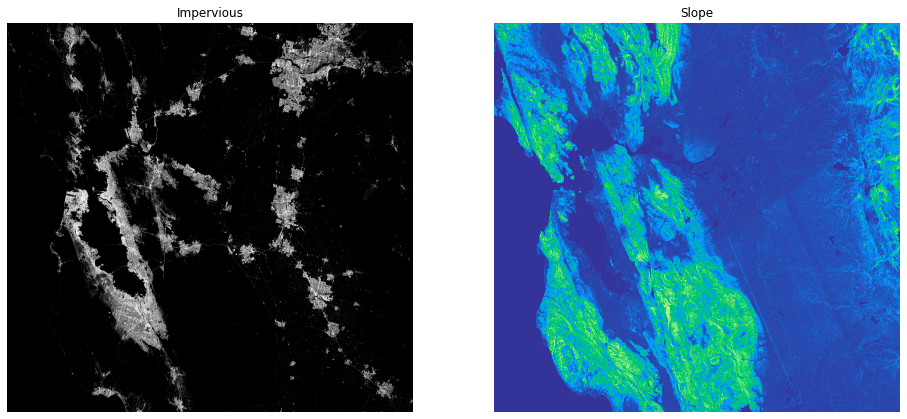

In [21]:
fig, axs = plt.subplots(1, 2, figsize = [16, 16])

axs[0].imshow(img[:, :, 1], cmap = 'gray')
axs[1].imshow(img[:, :, 2], cmap = 'terrain')

axs[0].set_title('Impervious')
axs[1].set_title('Slope')

axs[0].axis('off')
axs[1].axis('off')

plt.show()

We can see that rugged terrain makes a negative image of urbanism—at least around the bay—so it should be a decent predictor. Now we can check out the bands. 

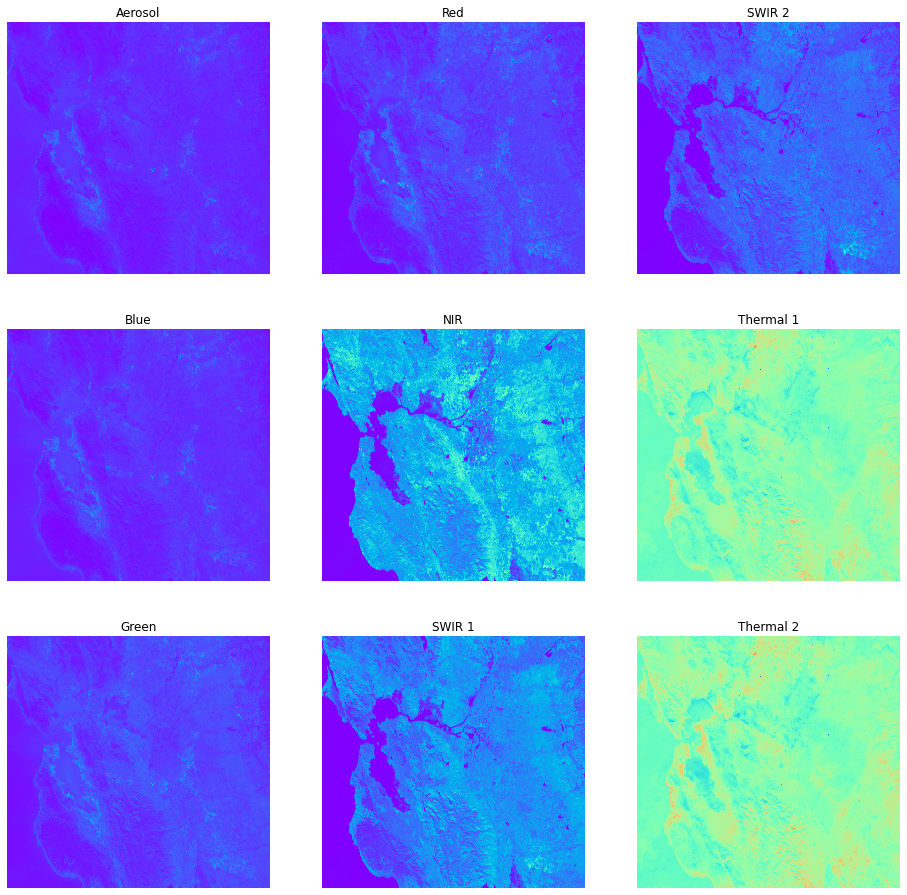

In [22]:
fig, axs = plt.subplots(3, 3, figsize = [16, 16])

#labels
opticalBands = ['Aerosol', 'Blue', 'Green', 'Red', 'NIR', 'SWIR 1', 'SWIR 2']
thermalBands = ['Thermal 1', 'Thermal 2']

BANDS = opticalBands + thermalBands

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      slot = i*3+j
      axs[j, i].axis('off')
      axs[j, i].imshow(img[:,:, slot + 3], cmap = 'rainbow')
      axs[j, i].set_title('{}'.format(BANDS[slot]))
        
plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
from sklearn.feature_extraction import image

Our u-net model takes 128 by 128 images, so we can to chop it up into patches. This would be impossible computationally, so we see up a maximum and randomly select patches from the image. You can adjust this number based on available memory. 

In [10]:
patches = image.extract_patches_2d(img, (128, 128), max_patches = 1000, random_state = 42)
print(patches.shape)

(1000, 128, 128, 21)


We want to slice off the response variable.

In [11]:
masks = patches[:, :, :, :1]
print(masks.shape)

(1000, 128, 128, 1)


Then we want to convert all urban development—classes 21 to 24—and all else into a binary, because this project is concerned with developed and undeveloped land. 

In [0]:
flat = masks.flatten()

#not urban
flat = np.where((flat < 21) | (flat > 24), 0, flat)

#urban
flat = np.where((flat > 20) & (flat < 25), 1, flat)

square = flat.reshape(masks.shape)

Now we want to slice off the predictor variables (notice that we left impervious surface behind, but will use it later). 

In [16]:
patches = patches[:, :, :, 2:]
patches.shape

(1000, 128, 128, 17)

In [0]:
from sklearn.model_selection import train_test_split

Separate the data into training and testing blocks.

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(patches, square, test_size = 0.4, random_state = 42)

In [0]:
from numpy import random

Plot a few to see how it looks—with the mask overlaid. 

(-0.5, 127.5, 127.5, -0.5)

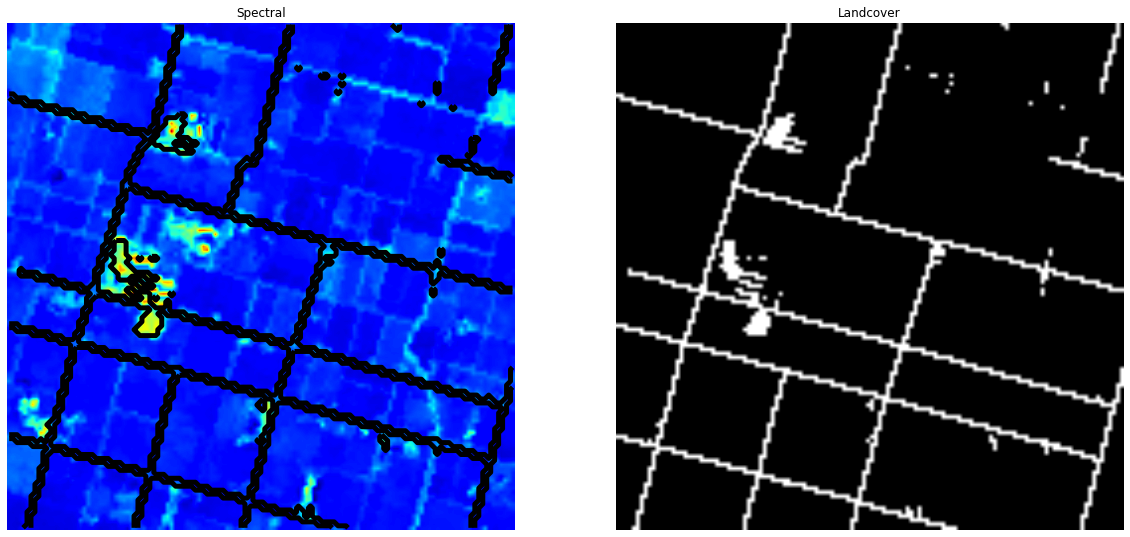

In [27]:
idx = random.randint(0, len(X_train))
has_mask = y_train[idx].max() > 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

#plot the image
ax1.imshow(X_train[idx, ..., 1], cmap = 'jet', interpolation = 'bilinear')

#add the mask
if has_mask: 
    ax1.contour(y_train[idx].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Spectral')

#compare to the response variable
ax2.imshow(y_train[idx].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Landcover')

ax1.axis('off')
ax2.axis('off')

Compile the model. We use an Adam optimizer here because it [appears to be](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) the prevailing optimizer, capturing many of the benefits of SGD and RMSprop.  

In [0]:
input_img = Input((128, 128, 19), name = 'img')
model = get_unet(input_img, n_filters = 16, dropout = 0.05, batchnorm = True)
model.compile(optimizer = Adam(), loss = "binary_crossentropy", metrics = ["accuracy"])

In [87]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 19) 0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 2752        img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 128, 128, 16) 64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 128, 128, 16) 0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [0]:
from keras.utils import plot_model

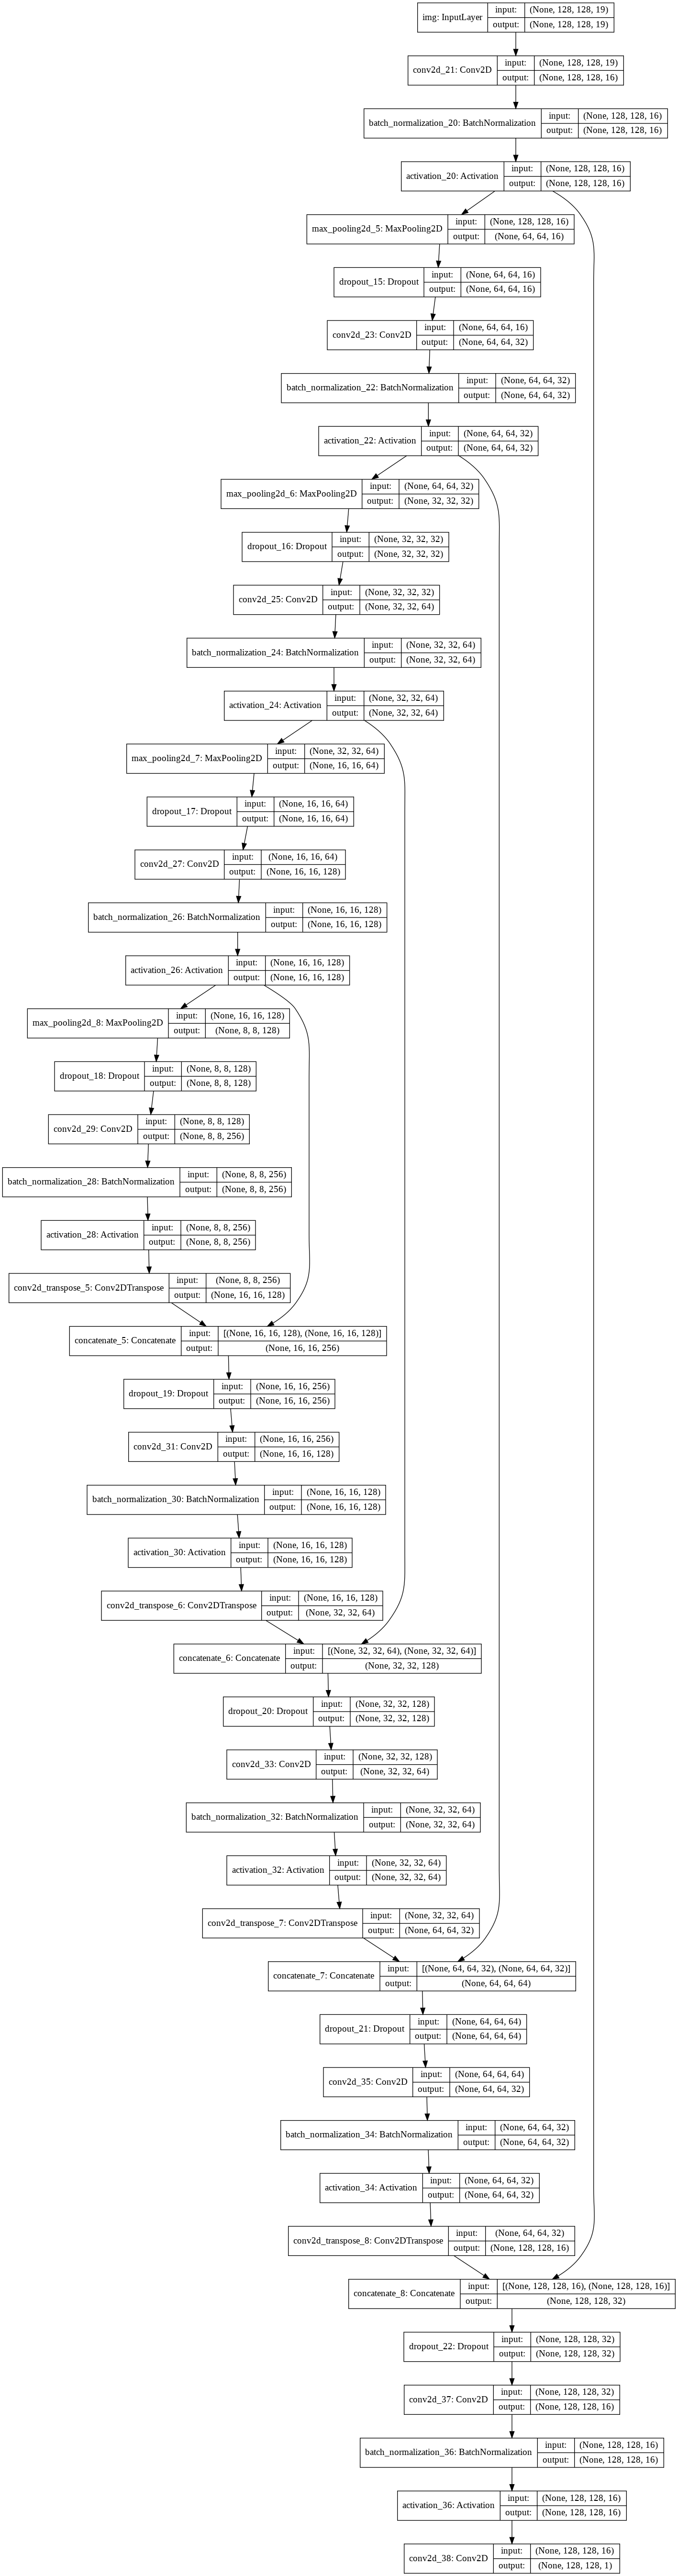

In [89]:
plot_model(model, show_shapes = True, show_layer_names = True)

We give it many epochs to converge on the best weights, but allow for early stopping in case the model gets there early. 

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lc-conv-test.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

Now we fit the model.

In [43]:
results = model.fit(X_train, y_train, 
                    batch_size = BATCH, 
                    epochs = EPOCH, 
                    callbacks = callbacks,
                    validation_data = (X_valid, y_valid))

Train on 600 samples, validate on 400 samples
Epoch 1/100
600/600 [==============================] - 11s 19ms/step - loss: 0.6117 - accuracy: 0.6788 - val_loss: 45.5448 - val_accuracy: 0.2687

Epoch 00001: val_loss improved from inf to 45.54478, saving model to model-lc-conv-test.h5
Epoch 2/100
600/600 [==============================] - 2s 3ms/step - loss: 0.4974 - accuracy: 0.8253 - val_loss: 4.8137 - val_accuracy: 0.6493

Epoch 00002: val_loss improved from 45.54478 to 4.81370, saving model to model-lc-conv-test.h5
Epoch 3/100
600/600 [==============================] - 2s 3ms/step - loss: 0.4460 - accuracy: 0.8457 - val_loss: 2.9146 - val_accuracy: 0.6240

Epoch 00003: val_loss improved from 4.81370 to 2.91457, saving model to model-lc-conv-test.h5
Epoch 4/100
600/600 [==============================] - 2s 3ms/step - loss: 0.3904 - accuracy: 0.8819 - val_loss: 2.0444 - val_accuracy: 0.5486

Epoch 00004: val_loss improved from 2.91457 to 2.04438, saving model to model-lc-conv-test.h5
E

The model is pretty accurate.

In [44]:
score = model.evaluate(X_valid, y_valid, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.19288437128067015
Test accuracy:  0.9367448687553406


#### Testing on all

Now we need to see if it can predict on a more diverse array of regions. This will require a good amount of memory, and `garbage collector` clears out objects that are no longer in use—usually after loops.  

In [0]:
import gc
gc.enable()

In [0]:
import numpy as np
import tifffile as tiff

from sklearn.feature_extraction import image

We run loops to download each image a cut patches from it before downloading the next, automating the process. 

In [8]:
directory = '/content/drive/My Drive/final/patches'

data = np.empty((0, 128, 128, 21))

for i in np.arange(0, 4):
  #load one file
  file = ("/training_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  #extract patches
  patches = image.extract_patches_2d(img, (128, 128), max_patches = 400, random_state = 42)

  #add them to our data
  data = np.concatenate((data, patches))

/training_comp_0.tif
/training_comp_1.tif
/training_comp_2.tif
/training_comp_3.tif


In [9]:
for i in np.arange(0, 4):
  file = ("/testing_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  patches = image.extract_patches_2d(img, (128, 128), max_patches = 400, random_state = 42)

  #keep adding to the same array
  data = np.concatenate((data, patches))

/testing_comp_0.tif
/testing_comp_1.tif
/testing_comp_2.tif
/testing_comp_3.tif


In [0]:
img = "nothing"

We check on our data and the clear out the old objects. 

In [11]:
patches = data
print(patches.shape)

(3200, 128, 128, 21)

In [12]:
gc.collect()

130

In [13]:
masks = patches[:, :, :, :1]
print(masks.shape)

(3200, 128, 128, 1)

Again, we need to isolate urban and non-urban.

In [0]:
flat = masks.flatten()

flat = np.where((flat < 21) | (flat > 24), 0, flat)
flat = np.where((flat > 20) & (flat < 25), 1, flat)

masks = flat.reshape(masks.shape)

Check on the predictors. 

In [15]:
patches = patches[:, :, :, 2:]
print(patches.shape)

(3200, 128, 128, 19)

These may not really work, but I want to clear out pointers by assigning objects to new data that require less memory. 

In [0]:
flat = "nothing"

gc.collect()

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(patches, masks, test_size = 0.4, random_state = 42)

We use the same hyperparameters are last time, so all we are changing is the data fed into the model. 

In [0]:
input_img = Input((128, 128, 19), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lc-conv.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
results = model.fit(X_train, y_train, 
                    batch_size = BATCH, 
                    epochs = EPOCH, 
                    callbacks = callbacks,
                    validation_data = (X_valid, y_valid))

Train on 1920 samples, validate on 1280 samples
Epoch 1/100
1920/1920 [==============================] - 12s 6ms/step - loss: 0.4721 - accuracy: 0.7926 - val_loss: 0.4848 - val_accuracy: 0.7867

Epoch 00001: val_loss improved from inf to 0.48481, saving model to model-lc-conv.h5
Epoch 2/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.3574 - accuracy: 0.8612 - val_loss: 0.5292 - val_accuracy: 0.7912

Epoch 00002: val_loss did not improve from 0.48481
Epoch 3/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.3335 - accuracy: 0.8701 - val_loss: 0.3816 - val_accuracy: 0.8380

Epoch 00003: val_loss improved from 0.48481 to 0.38158, saving model to model-lc-conv.h5
Epoch 4/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.3170 - accuracy: 0.8765 - val_loss: 0.4307 - val_accuracy: 0.7993

Epoch 00004: val_loss did not improve from 0.38158
Epoch 5/100
1920/1920 [==============================] - 10s 5ms/step - loss: 0.3032 - a

It still holds up, though the injection of variability cost some accuracy. 

In [0]:
score = model.evaluate(X_valid, y_valid, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.2059366602450609
Test accuracy:  0.9258022308349609


This is the more important model so we save its results. 

In [0]:
model.save_weights(directory + '/checkpoint_conv')

In [0]:
model.load_weights(directory + '/checkpoint_conv')

Now we can look at what is going on inside the model; we can begin by looking at the probabilities given by the model to each pixel—the possibility that each one is developed. 

In [0]:
y_pred = model.predict(X_valid)

In [0]:
import matplotlib
import matplotlib.pyplot as plt

We can plot them alongside the ground truth—the masks—and a composite image to see how it looks to us. 

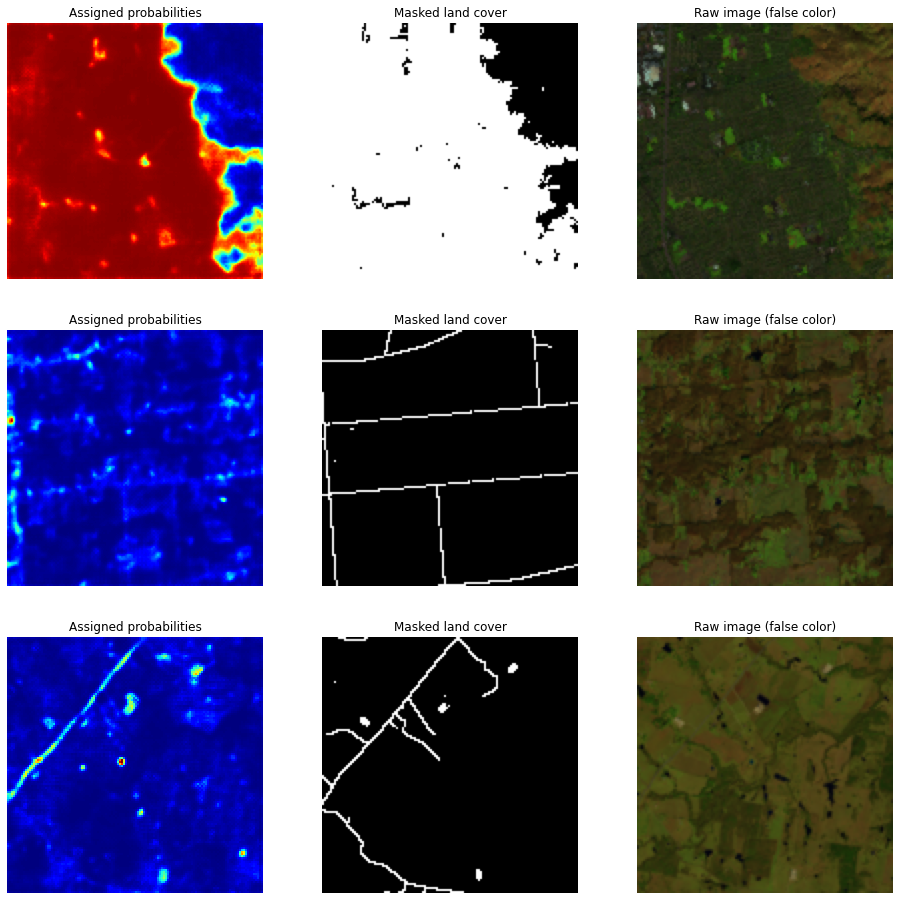

In [40]:
idx = np.random.randint(1, y_valid.shape[0], 3)

fig, axs = plt.subplots(3, 3, figsize = [16, 16])

for i in np.arange(0, 3):
      slot = i
      img = y_pred[idx[slot]][:, :, 0]
      axs[i, 0].set_title("Assigned probabilities")
      axs[i, 0].imshow(img, cmap = 'jet')
      axs[i, 0].set_axis_off()
      img = y_valid[idx[slot]][:, :, 0]
      axs[i, 1].set_title("Masked land cover")
      axs[i, 1].imshow(img, cmap = 'gray')
      axs[i, 1].set_axis_off()
      img = X_valid[idx[slot]][:, :, (6, 5, 3)]
      axs[i, 2].set_title("Raw image (false color)")
      axs[i, 2].imshow(img)
      axs[i, 2].set_axis_off()

plt.show()

These looks reasonable, capturing a suburban subdivision nicely. It struggles with roads, but even though it does not give them *high* probabilities, it gives them *higher* probabilities than surrounding fields, suggesting that it is picking up on something. Now we can make a confusion matrix. 

In [22]:
y_pred = model.predict(X_valid, verbose = 1) > 0.5
y_pred = y_pred.astype('uint8')

y_real = y_valid.flatten()
y_pred = y_pred.flatten()

1280/1280 [==============================] - 10s 8ms/step


In [0]:
from sklearn.metrics import confusion_matrix

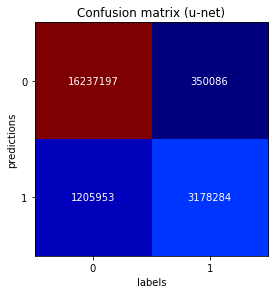

In [36]:
cm = confusion_matrix(y_real, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap = 'jet')

ax.set_yticks(np.arange(len(np.unique(y_pred))))
ax.set_xticks(np.arange(len(np.unique(y_real))))
ax.set_yticklabels(np.unique(y_pred))
ax.set_xticklabels(np.unique(y_real))

for i in range(len(np.unique(y_pred))):
    for j in range(len(np.unique(y_real))):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion matrix (u-net)")
fig.tight_layout()

plt.ylabel('predictions')
plt.xlabel('labels')
plt.show()

Our model struggles with false positives—oddly enough, given the above images—but the largest shares of its predictions go to true negatives (of which there are many) and true positives.

In [0]:
import pandas as pd

Save the model history for future comparison. 

In [0]:
pd.DataFrame(results.history).to_csv(directory + "/history_conv.csv")

### Conventional

In [37]:
!pip install tifffile

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Specifiying the model

In [0]:
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

EPOCH = 100
BATCH = 32 

This is our second, conventional model—a multilayer perceptron (MLP). As is abundantly clear from the images, the classes are not linearly separable, so hidden layers are required. For this reason, our flat model—which uses no convolutions and can only consider data at each pixel—began with an input layer and a hidden layer. The additional layers were added after initial testing and this block of five layers, with dropout to prevent overfitting, performed best.

In [0]:
def get_mlp():
  model = Sequential()
  
  model.add(Dense(128, activation='relu', input_shape=(19,)))
  model.add(Dropout(0.2))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(num_classes, activation='softmax'))

  return model

#### Testing on one

In [0]:
directory = '/content/drive/My Drive/final/patches'
path = directory + '/training_comp_0.tif'

In [0]:
import tifffile as tiff

We can load in a sample to see how this model performs. 

In [94]:
img = tiff.imread(path)
print(img.shape)

(6410, 6690, 21)


In [0]:
import numpy as np

In [0]:
img[np.isnan(img)] = 0

This requires the same reclassification. 

In [97]:
resp = img[:, :, 0].flatten()

#urban and non-urban
resp = np.where((resp < 21) | (resp > 24), 0, resp)
resp = np.where((resp > 20) & (resp < 25), 1, resp)
print(resp.shape)

#zeros for the predictor variables
pred = np.zeros([resp.shape[0], 19])
print(pred.shape)

(42882900,)
(42882900, 19)


In [98]:
np.unique(resp)

array([0., 1.], dtype=float32)

In [0]:
from sklearn import preprocessing

To construct the predictor, we are going to loop through each band, flatten it and scale it (we did not scale in the previous section because the model did not see to benefit from it and memory was precious) before pushing it into the array of zeros. The result is no longer an image, but an array that is essentially long pixels and wide bands. 

In [0]:
for i in np.arange(0, pred.shape[1]):
  data = img[:, :, i + 2]

  scaler = preprocessing.StandardScaler().fit(data)
  scaled = scaler.transform(data)
  pred[:, i] = scaled.flatten()

Because the image so large, we sample 100,000 pixels from it. 

In [0]:
idx = np.random.randint(0, len(resp), 100000)

resp = resp[idx]
pred = pred[idx, :]

In [0]:
from sklearn.model_selection import train_test_split

Again, we separate it into training and testing data. 

In [0]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp, test_size = 0.5, random_state = 42)

In [0]:
from keras.utils import to_categorical
from keras.utils import np_utils

In [0]:
num_classes = 2

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
from keras.optimizers import SGD

In [0]:
sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lc-mlp-test.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

For this model, which runs faster than the u-net, we can use a stochastic gradient descent (SGD) which often gives better results but is slower. 

In [0]:
model = get_mlp()
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [0]:
from keras.utils import plot_model

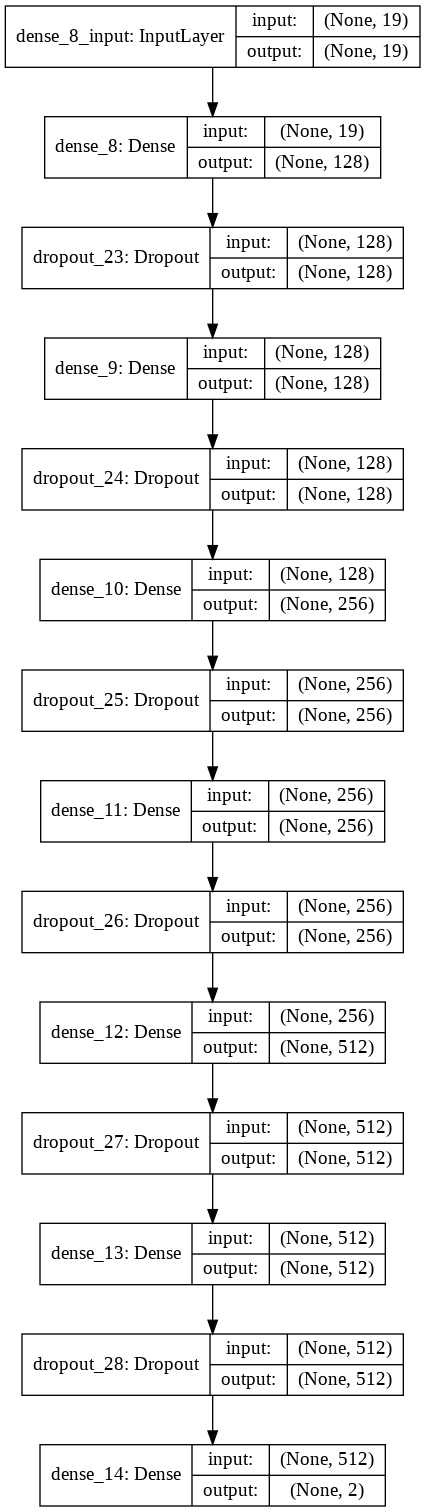

In [110]:
plot_model(model, show_shapes = True, show_layer_names = True)

In [40]:
history = model.fit(X_train, y_train,
                    epochs = EPOCH,
                    batch_size = BATCH,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test))

Train on 50000 samples, validate on 50000 samples
Epoch 1/100
50000/50000 [==============================] - 10s 206us/step - loss: 0.2660 - accuracy: 0.9059 - val_loss: 0.2335 - val_accuracy: 0.9184

Epoch 00001: val_loss improved from inf to 0.23352, saving model to model-lc-mlp-test.h5
Epoch 2/100
50000/50000 [==============================] - 10s 203us/step - loss: 0.2275 - accuracy: 0.9219 - val_loss: 0.2142 - val_accuracy: 0.9227

Epoch 00002: val_loss improved from 0.23352 to 0.21419, saving model to model-lc-mlp-test.h5
Epoch 3/100
50000/50000 [==============================] - 10s 204us/step - loss: 0.2167 - accuracy: 0.9250 - val_loss: 0.2125 - val_accuracy: 0.9251

Epoch 00003: val_loss improved from 0.21419 to 0.21252, saving model to model-lc-mlp-test.h5
Epoch 4/100
50000/50000 [==============================] - 10s 202us/step - loss: 0.2110 - accuracy: 0.9271 - val_loss: 0.2045 - val_accuracy: 0.9280

Epoch 00004: val_loss improved from 0.21252 to 0.20454, saving model to

This model peforms almost identically to its u-net counterpart. 

In [41]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.17618987893104554
Test accuracy:  0.9367799758911133


#### Testing on all

Now we want to sample the whole country. To do this we are going to read each image and sample it just as we did above. 

In [0]:
from sklearn import preprocessing

In [42]:
directory = '/content/drive/My Drive/final/patches'

data = np.empty((0, 150, 21))

#loop through and select pixels at random
for i in np.arange(0, 4):
  file = ("/training_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  img = img[:, np.random.randint(0, img.shape[1], 150), :]
  img = img[np.random.randint(0, img.shape[0], 150), :, :]

  data = np.concatenate((data, img))

/training_comp_0.tif
/training_comp_1.tif
/training_comp_2.tif
/training_comp_3.tif


In [43]:
for i in np.arange(0, 4):
  file = ("/testing_comp_{}.tif".format(i))
  path = directory + file
  print(file)
  
  img = tiff.imread(path)
  img[np.isnan(img)] = 0

  img = img[:, np.random.randint(0, img.shape[1], 150), :]
  img = img[np.random.randint(0, img.shape[0], 150), :, :]

  data = np.concatenate((data, img))

/testing_comp_0.tif
/testing_comp_1.tif
/testing_comp_2.tif
/testing_comp_3.tif


Check to make sure it worked.

In [44]:
print(data.shape)

(1200, 150, 21)


In [45]:
resp = data[:, :, 0].flatten()

resp = np.where((resp < 21) | (resp > 24), 0, resp)
resp = np.where((resp > 20) & (resp < 25), 1, resp)
print(resp.shape)

pred = np.zeros([resp.shape[0], 20])
print(pred.shape)

(180000,)
(180000, 20)


In [0]:
from sklearn import preprocessing

We also want to reshape and preprocess the data as before.

In [0]:
for i in np.arange(0, pred.shape[1]):
  temp = data[:, :, i + 1]

  scaler = preprocessing.StandardScaler().fit(temp)
  scaled = scaler.transform(temp)
  pred[:, i] = scaled.flatten()

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(pred, resp, test_size = 0.5, random_state = 42)

In [0]:
imp_train = X_train[:, 0]
imp_test = X_test[:, 0]

X_train = X_train[:, 1:]
X_test = X_test[:, 1:]

In [0]:
from keras.utils import to_categorical
from keras.utils import np_utils

In [0]:
num_classes = 2

y_train = np_utils.to_categorical(y_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

In [0]:
from keras.optimizers import SGD

In [0]:
sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-lc-mlp-test.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

With new data but old hyperparaters, we are reading to compile the model. 

In [0]:
model = get_mlp()
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [63]:
history = model.fit(X_train, y_train,
                    epochs = EPOCH,
                    batch_size = BATCH,
                    callbacks = callbacks,
                    validation_data = (X_test, y_test))

Train on 90000 samples, validate on 90000 samples
Epoch 1/100
90000/90000 [==============================] - 20s 219us/step - loss: 0.2939 - accuracy: 0.8900 - val_loss: 0.2734 - val_accuracy: 0.8991

Epoch 00001: val_loss improved from inf to 0.27341, saving model to model-lc-mlp-test.h5
Epoch 2/100
90000/90000 [==============================] - 20s 217us/step - loss: 0.2642 - accuracy: 0.9026 - val_loss: 0.2637 - val_accuracy: 0.9048

Epoch 00002: val_loss improved from 0.27341 to 0.26373, saving model to model-lc-mlp-test.h5
Epoch 3/100
90000/90000 [==============================] - 19s 210us/step - loss: 0.2573 - accuracy: 0.9054 - val_loss: 0.2574 - val_accuracy: 0.9048

Epoch 00003: val_loss improved from 0.26373 to 0.25744, saving model to model-lc-mlp-test.h5
Epoch 4/100
90000/90000 [==============================] - 19s 207us/step - loss: 0.2540 - accuracy: 0.9059 - val_loss: 0.2516 - val_accuracy: 0.9075

Epoch 00004: val_loss improved from 0.25744 to 0.25161, saving model to

This one lost a fair amount of accuracy, suggesting that this approach may not be able to manage variability. 

In [64]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  0.22915414777464338
Test accuracy:  0.9152777791023254


Save the results. 

In [0]:
model.save_weights(directory + '/checkpoint_mlp')

In [0]:
model.load_weights(directory + '/checkpoint_mlp')

In [0]:
import matplotlib
import matplotlib.pyplot as plt

In [0]:
directory = '/content/drive/My Drive/final/patches'
path = directory + '/training_comp_0.tif'

In [0]:
import tifffile as tiff

With this one, we can predict an entire region. 

In [108]:
img = tiff.imread(path)
print(img.shape)

(6410, 6690, 21)


In [0]:
import numpy as np

In [0]:
img[np.isnan(img)] = 0

Here, though, to see how probabilities correlate with impervious surface—a continuous variable—we can grab that from the data. 

In [21]:
resp = img[:, :, 1]
flat = resp.flatten()
print(flat.shape)

pred = np.zeros([flat.shape[0], 19])
print(pred.shape)

(42882900,)
(42882900, 19)


In [0]:
from sklearn import preprocessing

In [0]:
for i in np.arange(0, pred.shape[1]):
  data = img[:, :, i + 2]

  scaler = preprocessing.StandardScaler().fit(data)
  scaled = scaler.transform(data)
  pred[:, i] = scaled.flatten()

Note that predicting here takes up to a half hour. 

In [24]:
y_pred = model.predict(pred, verbose = 1)
y_pred = y_pred[:, 1].reshape(resp.shape)

42882900/42882900 [==============================] - 1167s 27us/step


In [36]:
mask = img[:, :, 0]
mask = np.ma.masked_where(mask != 0, mask)

(6410, 6690)

We can compare the images by putting predictions alongside ground truth. 

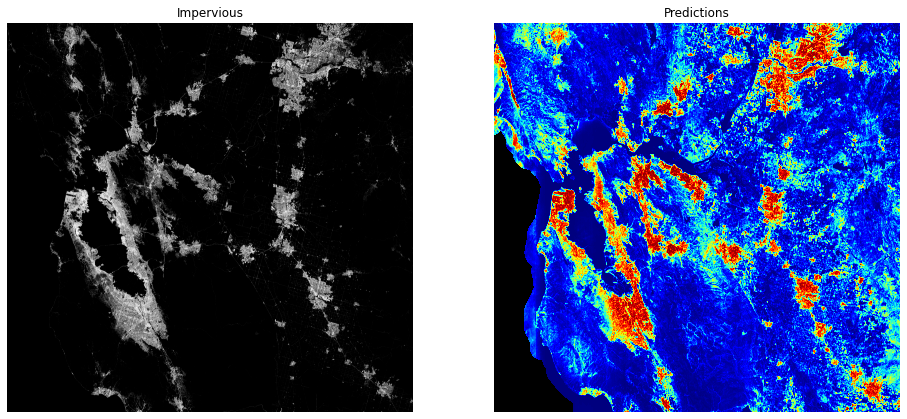

In [38]:
fig, axs = plt.subplots(1, 2, figsize = [16, 16])

axs[0].imshow(resp, cmap = 'gray')
axs[1].imshow(y_pred, cmap = 'jet')

axs[1].imshow(mask, cmap = 'gray')

axs[0].set_title('Impervious')
axs[1].set_title('Predictions')

axs[0].axis('off')
axs[1].axis('off')

plt.show()

The highest probabilities indeed correlate with the highest levels of impervious surface. There is, however, an area of heightened error in the northwest and one in the southeast. Coastal aerosols may be influencing the prediction in the former and pollution in the central vallery may be influencing the latter, but this is not entirely clear. 

In [58]:
y_pred = model.predict_classes(X_test, verbose = 1)
y_real = np.argmax(y_test, axis = 1)

90000/90000 [==============================] - 3s 36us/step


Now we can make another confusion matrix, which tells much the same story. 

In [0]:
from sklearn.metrics import confusion_matrix

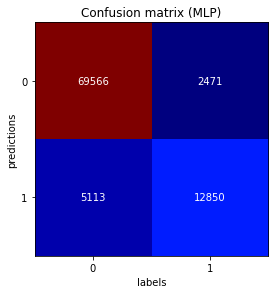

In [60]:
cm = confusion_matrix(y_real, y_pred)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap = 'jet')

ax.set_yticks(np.arange(len(np.unique(y_pred))))
ax.set_xticks(np.arange(len(np.unique(y_real))))
ax.set_yticklabels(np.unique(y_pred))
ax.set_xticklabels(np.unique(y_real))

for i in range(len(np.unique(y_pred))):
    for j in range(len(np.unique(y_real))):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Confusion matrix (MLP)")
fig.tight_layout()

plt.ylabel('predictions')
plt.xlabel('labels')
plt.show()

Again, true values are the must numerous but there is still an issue with false positives. We can plot impervious surface on one axis and probabilities on another to see if that clears things up.  

90000/90000 [==============================] - 3s 39us/step


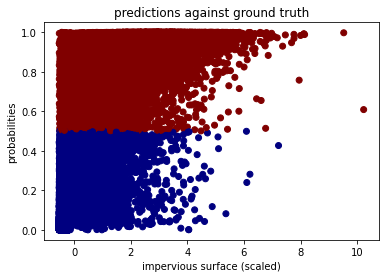

In [122]:
fig, ax = plt.subplots()

probs = model.predict(X_test, verbose = 1)
color = model.predict_classes(X_test, verbose = 1)
probs = probs[:, 1]

ax.scatter(imp_test, probs, c = color, cmap = 'jet')

ax.set_title("predictions against ground truth")

plt.xlabel('impervious surface (scaled)')
plt.ylabel('probabilities')
plt.show()

Though the most developed areas feature the highest proabilities, there is still a lot of confusion around un- and under-developed pixels. 

In [0]:
import pandas as pd

In [0]:
pd.DataFrame(history.history).to_csv(directory + "/history_conv.csv")

### Comparison

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
directory = '/content/drive/My Drive/final/patches'

In [0]:
import pandas as pd

Finally, we can recover the histories of both models to see how the compare. 

In [0]:
conven = pd.read_csv(directory + "/history_mlp.csv")
convol = pd.read_csv(directory + "/history_unet.csv")

In [38]:
convol.head()

Unnamed: 0  val_loss  val_accuracy      loss  accuracy     lr
0           0  0.484811      0.786706  0.472084  0.792565  0.001
1           1  0.529157      0.791155  0.357351  0.861181  0.001
2           2  0.381577      0.838039  0.333476  0.870147  0.001
3           3  0.430673      0.799306  0.317038  0.876509  0.001
4           4  0.353701      0.868410  0.303225  0.885210  0.001

In [0]:
one_val_loss = convol['val_loss']
two_val_loss = conven['val_loss']

one_train_loss = convol['loss']
two_train_loss = conven['loss']

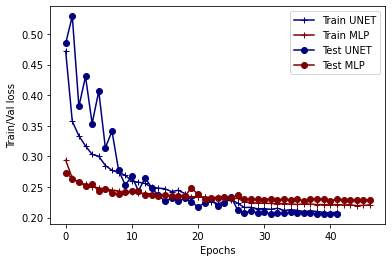

In [40]:
plt.plot(one_train_loss, color = '#00007f', marker = '+', label = 'Train UNET')
plt.plot(two_train_loss, color = '#7f0000', marker = '+', label = 'Train MLP')

plt.plot(one_val_loss, color = '#00007f', marker = 'o', label = 'Test UNET')
plt.plot(two_val_loss, color = '#7f0000', marker = 'o', label = 'Test MLP')

plt.xlabel('Epochs')
plt.ylabel('Train/Val loss')
plt.legend()

plt.show()

Measuring loss, we can see that after some initial problems, the u-net model performs better. 

In [0]:
one_val_loss = convol['val_accuracy']
two_val_loss = conven['val_accuracy']

one_train_loss = convol['accuracy']
two_train_loss = conven['accuracy']

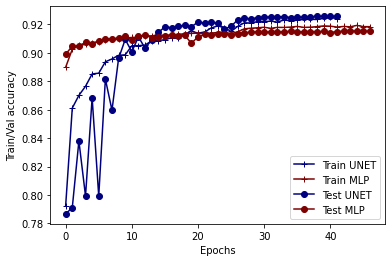

In [42]:
plt.plot(one_train_loss, color = '#00007f', marker = '+', label = 'Train UNET')
plt.plot(two_train_loss, color = '#7f0000', marker = '+', label = 'Train MLP')

plt.plot(one_val_loss, color = '#00007f', marker = 'o', label = 'Test UNET')
plt.plot(two_val_loss, color = '#7f0000', marker = 'o', label = 'Test MLP')

plt.xlabel('Epochs')
plt.ylabel('Train/Val accuracy')
plt.legend()

plt.show()

The same goes for accuracy. With wild swings early one, the model then settled into a far better accuracy. 